In [1]:
import pandas as pd
import numpy as np
import os
import prody
import math

from pathlib import Path
import pickle
import sys
from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error

ABPRED_DIR = Path.cwd().parent
if ABPRED_DIR not in sys.path:
    sys.path.append(str(ABPRED_DIR))
    
from AbPred.interface_contacts import InterfaceContacts
from AbPred.features_ic import ArpeggioFeatures

/mnt/d/Python_projects/AbPred/AbPred/../libs/arpeggio


In [2]:
def Kd_2_dG(Kd):
    if Kd == 0:
        
        deltaG = np.log(Kd+1)*(8.314/4184)*(298.15)
    else:
        deltaG = np.log(Kd)*(8.314/4184)*(298.15)
    
    return deltaG

def deltaG_to_Kd(delg):
    Kd_value = math.exp((delg)/((8.314/4184)*298.15))
    return Kd_value

The effect of a given mutation on antibody binding was represented by apparent affinity (avidity) relative to those for wild-type (WT) gp120, calculated with the formula ([(EC50_WT/EC50_mutant)/(EC50_WT for 2G12/EC50_mutant for 2G12)] × 100)

In [3]:
# Test data
VIH_final = pd.read_csv('../data/VIH_Test15.csv',index_col=0)

# original info data
vih_data = pd.read_csv("../data/HIV_escape_mutations.csv",sep="\t")

In [4]:

#vih_data["pred_ddg2EC50"] = vih_data["mCSM-AB_Pred"].apply(deltaG_to_Kd)*100

In [5]:
vih_original = vih_data.loc[vih_data["Mutation_type"]=="ORIGINAL"].copy()
vih_reverse = vih_data.loc[vih_data["Mutation_type"]=="REVERSE"]

#sort values to appedn to prediction data table
vih_original.loc[:,"mut_code"] = (vih_reverse["Chain"]+vih_reverse["Mutation"].str[1:]).values
vih_original.sort_values(by='mut_code',inplace=True)


In [6]:
vih_original.loc[(vih_original['Exptal'] < 33 ),"mutation-effect"] = "decreased"
vih_original.loc[(vih_original['Exptal'] > 300 ),"mutation-effect"] = "increased"
vih_original.loc[(vih_original['Exptal'] < 300 )&(vih_original['Exptal'] > 33 ),"mutation-effect"] = "neutral"

In [7]:
vih_original

,Mutation_type,Chain,Mutation,log10(Exptal),Exptal,mCSM-AB_Pred,mut_code,mutation-effect
8,ORIGINAL,G,A163N,1.863323,72.0,-0.010,G163A,neutral
9,ORIGINAL,G,K163N,1.973128,93.0,-0.299,G163K,neutral
10,ORIGINAL,G,T163N,1.880814,75.0,-0.137,G163T,neutral
11,ORIGINAL,G,A165S,2.075547,118.0,0.113,G165A,neutral
12,ORIGINAL,G,A168T,2.012837,102.0,0.091,G168A,neutral
13,ORIGINAL,G,A176F,2.086360,121.0,-0.657,G176A,neutral
14,ORIGINAL,G,A179I,1.991226,97.0,-0.620,G179A,neutral
15,ORIGINAL,G,A218R,2.086360,121.0,0.039,G218A,neutral
16,ORIGINAL,G,A222S,1.919078,82.0,-0.496,G222A,neutral
17,ORIGINAL,G,A223T,1.602060,39.0,-0.549,G223A,neutral


In [8]:
#
#xgbr = XGBRegressor()
#xgbr.load_model(fname='xgb_final_400F_smote_032019.sav')

#xgbr_borderline = XGBRegressor()
#xgbr_borderline.load_model(fname='xgb_final_400F_borderlinesmote_032019.sav')


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesInteractions(BaseEstimator, TransformerMixin):
    
    #Class constructor method that takes ..
    def __init__(self, interaction1, interaction2 ):
        self.interaction1 = interaction1
        self.interaction2 = interaction2
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        
        return self
    
    def transform(self, X , y=None ):
        
        X_interactions = X.loc[:,self.interaction1].mul(X[self.interaction2],axis=0)
        X_interactions.columns = X_interactions.columns.values+'/{}'.format(self.interaction2)
        # set columns names
        
        X = X.join(X_interactions)
        
        return X
    
class SkewTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.6, method='quantile'):
        self.threshold = threshold
        self.method = method
        
    #Return self nothing else to do here
    def fit(self, X, y = None  ):
        skewes_ = X.skew().sort_values(ascending=False)
        self.skew_features = skewes_[skewes_.abs() > self.threshold]
        
        if self.method == 'quantile':
            self.t = QuantileTransformer(output_distribution="normal",random_state=13)
            self.t.fit(X[self.skew_features.index])
        
        return self
    
    def transform(self, X, y=None):
        
        X[self.skew_features.index] = self.t.transform(X[self.skew_features.index])
        
        return X
        
class ZeroThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=90.):
        self.threshold = threshold
    
    
    def fit(self, X, y = None  ):
        
        self.feature_names = X.columns
        self.overfit = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 >self.threshold:
                self.overfit.append(i)
        
        return self
    
    def transform(self, X, y=None):
        
        X.drop(self.overfit,axis=1,inplace=True)
        
        return X


In [13]:
# X and y data transformed to delta G
X = VIH_final.drop("Exptal",axis=1)
y_energy = (VIH_final["Exptal"]/1000).apply(Kd_2_dG)
y_binding = VIH_final["Exptal"].values

In [33]:
#ridge_model = joblib.load('ridgeLinear_train15skempiAB_FINAL.pkl')
lasso_model = joblib.load('Lasso_train15skempiAB_FINAL.pkl')
elasticnet_model = joblib.load('elasticNet_train15skempiAB_FINAL.pkl')
svr_model = joblib.load('rbfSVRmodel_train15skempiAB_FINAL.pkl')
poly_model = joblib.load("poly2SVRmodel_train15skempiAB_FINAL.pkl")
#rf_model = joblib.load('RFmodel_train15skempiAB_FINAL.pkl')
gbt_model = joblib.load('GBTmodel_train15skempiAB_FINAL.overf.pkl')
#xgb_model = joblib.load('XGBmodel_train15skempiAB_FINAL.pkl')

In [34]:
#ridge_pred = ridge_model.predict(X)
lasso_pred = lasso_model.predict(X)
elasticnet_pred = elasticnet_model.predict(X)
svr_pred = svr_model.predict(X)
poly_pred = poly_model.predict(X)
#rf_pred = rf_model.predict(X)
gbt_pred = gbt_model.predict(X)
#xgb_pred = xgb_model.predict(X)

In [35]:
pred_stack = np.hstack([vih_original[["mutation-effect","mCSM-AB_Pred","Exptal"]].values,
                        lasso_pred.reshape((-1,1)),gbt_pred.reshape((-1,1)),svr_pred.reshape((-1,1)),poly_pred.reshape((-1,1))])
pred_data = pd.DataFrame(pred_stack,columns=["mutation-effect","mCSM-AB_Pred","Exptal","Lasso_pred","gbt_pred","svr_pred","poly_pred"])
# transform prediction score to relative to kd , refered in paper
#pred_data_binding =  pred_data.applymap(deltaG_to_Kd)*100

In [36]:
pred_data["mean-pred"] = pred_data.loc[:,["Lasso_pred","gbt_pred","svr_pred"]].mean(axis=1)

In [39]:
pred_data

,mutation-effect,mCSM-AB_Pred,Exptal,Lasso_pred,gbt_pred,svr_pred,poly_pred,mean-pred
0,neutral,-0.01,72,0.444335,0.41421,0.0195679,-0.14287,0.292704
1,neutral,-0.299,93,0.111233,0.282559,0.0143758,0.244876,0.136056
2,neutral,-0.137,75,0.334032,0.270358,-0.0205933,-0.137635,0.194599
3,neutral,0.113,118,-0.0590185,-0.075386,0.0716098,0.109647,-0.020932
4,neutral,0.091,102,0.252544,0.0687501,0.114838,-0.165191,0.145377
5,neutral,-0.657,121,0.0705839,-0.130828,-0.0666253,-0.00738885,-0.042290
6,neutral,-0.62,97,0.111875,0.133737,0.136573,0.208813,0.127395
7,neutral,0.039,121,0.0840216,-0.0614337,-0.0193534,-0.322618,0.001078
8,neutral,-0.496,82,-0.0555754,0.0788652,0.0972592,0.104244,0.040183
9,neutral,-0.549,39,0.016215,-0.0134815,0.0108749,-0.0925824,0.004536


In [38]:
pred_data.loc[pred_data["mutation-effect"]=="increased"]

,mutation-effect,mCSM-AB_Pred,Exptal,Lasso_pred,gbt_pred,svr_pred,poly_pred,mean-pred
21,increased,0.033,303,0.152973,0.0289818,-0.0060517,-0.245438,0.058634
58,increased,-0.211,306,-0.0180738,-0.133638,-0.167213,-0.252052,-0.106308


In [20]:
pred_data.loc[(pred_data["mean-pred"].abs() > 0.1)]

,mutation-effect,mCSM-AB_Pred,Exptal,elasticnet_pred,gbt_pred,svr_pred,mean-pred
0,neutral,-0.01,72,0.474889,0.41421,0.0195679,0.302889
1,neutral,-0.299,93,0.233867,0.282559,0.0143758,0.176934
2,neutral,-0.137,75,0.370189,0.270358,-0.0205933,0.206651
4,neutral,0.091,102,0.316169,0.0687501,0.114838,0.166586
6,neutral,-0.62,97,0.207792,0.133737,0.136573,0.159367
11,neutral,0.005,59,0.364844,0.182102,0.0910775,0.212674
12,neutral,-0.797,193,0.640276,0.471908,0.508427,0.540203
13,decreased,-1.479,0,0.294367,0.043499,0.141071,0.159646
14,neutral,-1.203,66,0.534364,0.363215,0.328778,0.408786
24,neutral,0.023,101,-0.105217,-0.152855,-0.0869357,-0.115003


In [37]:
pred_data["True"] = y_energy.values
pred_data_binding["True"] = y_binding

In [38]:
#pred_data_converted.corr()
pred_data_binding.corr()

,elasticnet_pred,gbt_pred,mCSM-AB,True
elasticnet_pred,1.000000,0.807441,-0.228540,-0.239397
gbt_pred,0.807441,1.000000,-0.195745,-0.209765
mCSM-AB,-0.228540,-0.195745,1.000000,-0.024009
True,-0.239397,-0.209765,-0.024009,1.000000


In [39]:
pred_data

,elasticnet_pred,gbt_pred,mCSM-AB,True
0,0.474889,0.515569,-0.010,-0.194623
1,0.233867,0.010387,-0.299,-0.042995
2,0.370189,0.307020,-0.137,-0.170438
3,-0.071005,-0.122103,0.113,0.098059
4,0.316169,0.101043,0.091,0.011732
5,0.005259,-0.194960,-0.657,0.112933
6,0.207792,-0.015090,-0.620,-0.018046
7,-0.015655,-0.045781,0.039,0.112933
8,-0.093480,-0.083276,-0.496,-0.117573
9,-0.052793,-0.089318,-0.549,-0.557858


In [18]:
average_pred_binding = pred_data_binding.drop("True",axis=1).loc[:,["gbt_pred","elasticnet_pred"]].mean(axis=1)
average_pred_energy = pred_data.drop("True",axis=1).loc[:,["gbt_pred","elasticnet_pred"]].mean(axis=1)

In [19]:
r2score =  r2_score(y_energy,average_pred_energy)
rmse = mean_squared_error(y_energy,average_pred_energy)

print("R2 score:", r2score)
print("RMSE score:", np.sqrt(rmse))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [110]:
np.corrcoef(y["Exptal"],average_pred)

array([[ 1.        , -0.21694844],
       [-0.21694844,  1.        ]])

In [18]:
# Corr mCSM-AB with converted mCSM AB data
np.corrcoef(y_binding,vih_reverse["pred_ddg2EC50"])

array([[1.        , 0.27592822],
       [0.27592822, 1.        ]])

In [20]:
# Corr mCSM-AB with converted VIH paper data
np.corrcoef(y_energy,vih_reverse["mCSM-AB_Pred"])

array([[1.        , 0.21065497],
       [0.21065497, 1.        ]])

In [95]:
# Corr FoldX feature alone
np.corrcoef(y["Exptal"],VIH_final["dg_change"].apply(deltaG_to_Kd)*100)


array([[ 1.        , -0.27375191],
       [-0.27375191,  1.        ]])

In [180]:
import seaborn as sns

NameError: name 'plt' is not defined

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


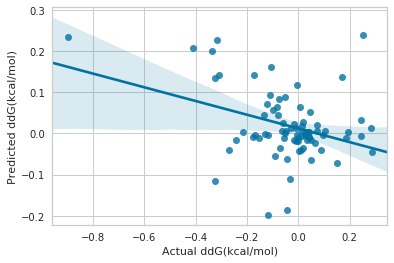

In [183]:
#rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": pred_data["gbt_pred"], "Actual ddG(kcal/mol)": y_energy.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
#plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

In [179]:
PredictionError?